In [347]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno

In [348]:
df = pd.read_csv('water_potability.csv')
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.05786,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [349]:

import pandas as pd

# load the CSV file into a DataFrame
df = pd.read_csv('water_potability.csv')

# separate the header row from the data rows
header_row = df.iloc[[0]]
data_rows = df.iloc[1:]

# shuffle the data rows without replacement
data_rows = data_rows.sample(frac=1).reset_index(drop=True)

# combine the shuffled data rows with the header row
shuffled_df = pd.concat([header_row, data_rows])

# write the shuffled DataFrame back to a CSV file
shuffled_df.to_csv('water_potability_shuffled_data.csv', index=False)


In [350]:
df = pd.read_csv('water_potability_shuffled_data.csv')
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890456,20791.318980,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,7.615557,204.869975,8403.284552,6.012316,418.309431,311.178955,12.742329,67.282328,4.243134,0
2,4.736405,203.276420,28698.729960,5.271367,323.683683,508.820341,14.063140,65.155182,4.995602,1
3,5.367546,175.432819,29009.010820,6.481444,NaN,463.478425,19.370234,67.286208,4.267190,0
4,10.509669,213.876872,16786.925410,6.624220,NaN,411.216978,16.590932,67.745515,3.505079,0


In [351]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690300,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833605,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762125,8.114887,359.950170,481.792305,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196010,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [352]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [353]:
#Dependent Variable Analysis

In [354]:
d = pd.DataFrame(df["Potability"].value_counts())
fig = px.pie(d, values = "Potability", names = ["Not Potable", "Potable"], hole = 0.4, opacity = 0.8,
                                               labels = {"label":"Potability", "Potability":"Number of Samples"})
fig.update_layout(title = dict(text = "Pie Chart of Potability Feature"))
fig.update_traces(textposition = "outside", textinfo = "percent + label")
fig.show()

In [355]:
#Correlation Between Feature

In [356]:
df.corr()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
ph,1.000000,0.082096,-0.089288,-0.034350,0.018203,0.018614,0.043503,0.003354,-0.039057,-0.003556
Hardness,0.082096,1.000000,-0.046899,-0.030054,-0.106923,-0.023915,0.003610,-0.013013,-0.014449,-0.013837
Solids,-0.089288,-0.046899,1.000000,-0.070148,-0.171804,0.013831,0.010242,-0.009143,0.019546,0.033743
Chloramines,-0.034350,-0.030054,-0.070148,1.000000,0.027244,-0.020486,-0.012653,0.017084,0.002363,0.023779
Sulfate,0.018203,-0.106923,-0.171804,0.027244,1.000000,-0.016121,0.030831,-0.030274,-0.011187,-0.023577
Conductivity,0.018614,-0.023915,0.013831,-0.020486,-0.016121,1.000000,0.020966,0.001285,0.005798,-0.008128
Organic_carbon,0.043503,0.003610,0.010242,-0.012653,0.030831,0.020966,1.000000,-0.013274,-0.027308,-0.030001
Trihalomethanes,0.003354,-0.013013,-0.009143,0.017084,-0.030274,0.001285,-0.013274,1.000000,-0.022145,0.007130
Turbidity,-0.039057,-0.014449,0.019546,0.002363,-0.011187,0.005798,-0.027308,-0.022145,1.000000,0.001581
Potability,-0.003556,-0.013837,0.033743,0.023779,-0.023577,-0.008128,-0.030001,0.007130,0.001581,1.000000


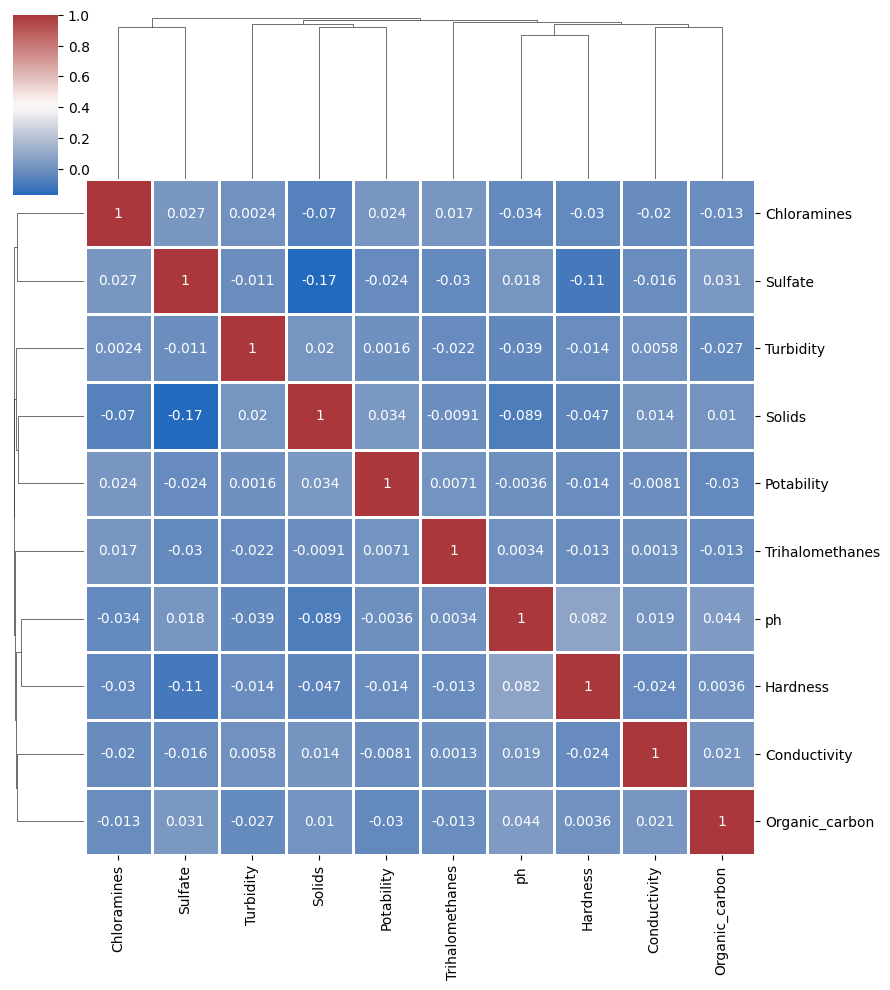

In [357]:
sns.clustermap(df.corr(), cmap = "vlag", dendrogram_ratio = (0.1, 0.2), annot = True, linewidth = 0.8, figsize = (9,10))
plt.show()

In [358]:
#Distribution of Feature

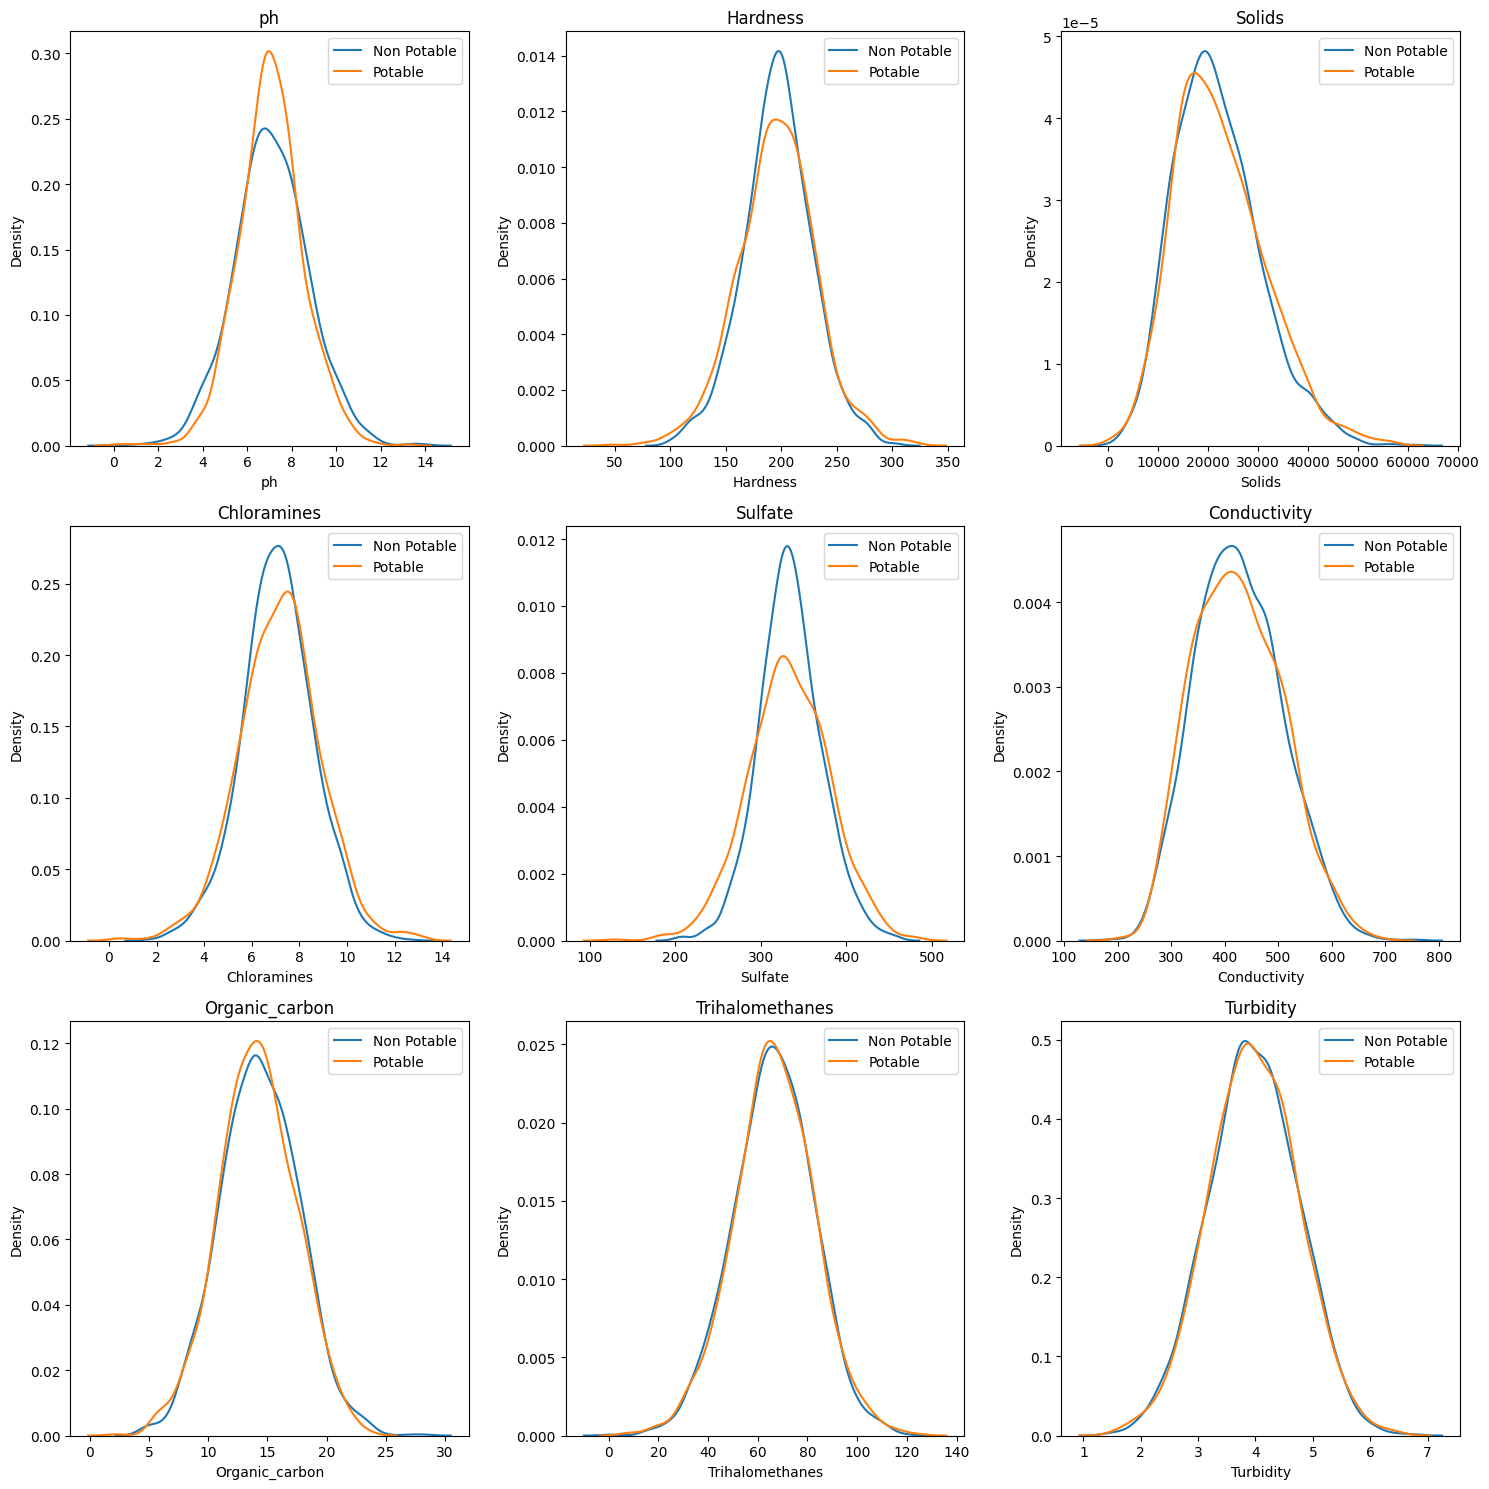

In [359]:
non_potable = df.query("Potability == 0")
potable = df.query("Potability == 1")

plt.figure(figsize = (15,15))
for ax, col in  enumerate(df.columns[:9]):
    plt.subplot(3,3, ax+1)
    plt.title(col)
    sns.kdeplot(x = non_potable[col], label = "Non Potable")
    sns.kdeplot(x = potable[col], label = "Potable")
    plt.legend()
plt.tight_layout()

In [360]:
#Preprocessing: Missing Value problem

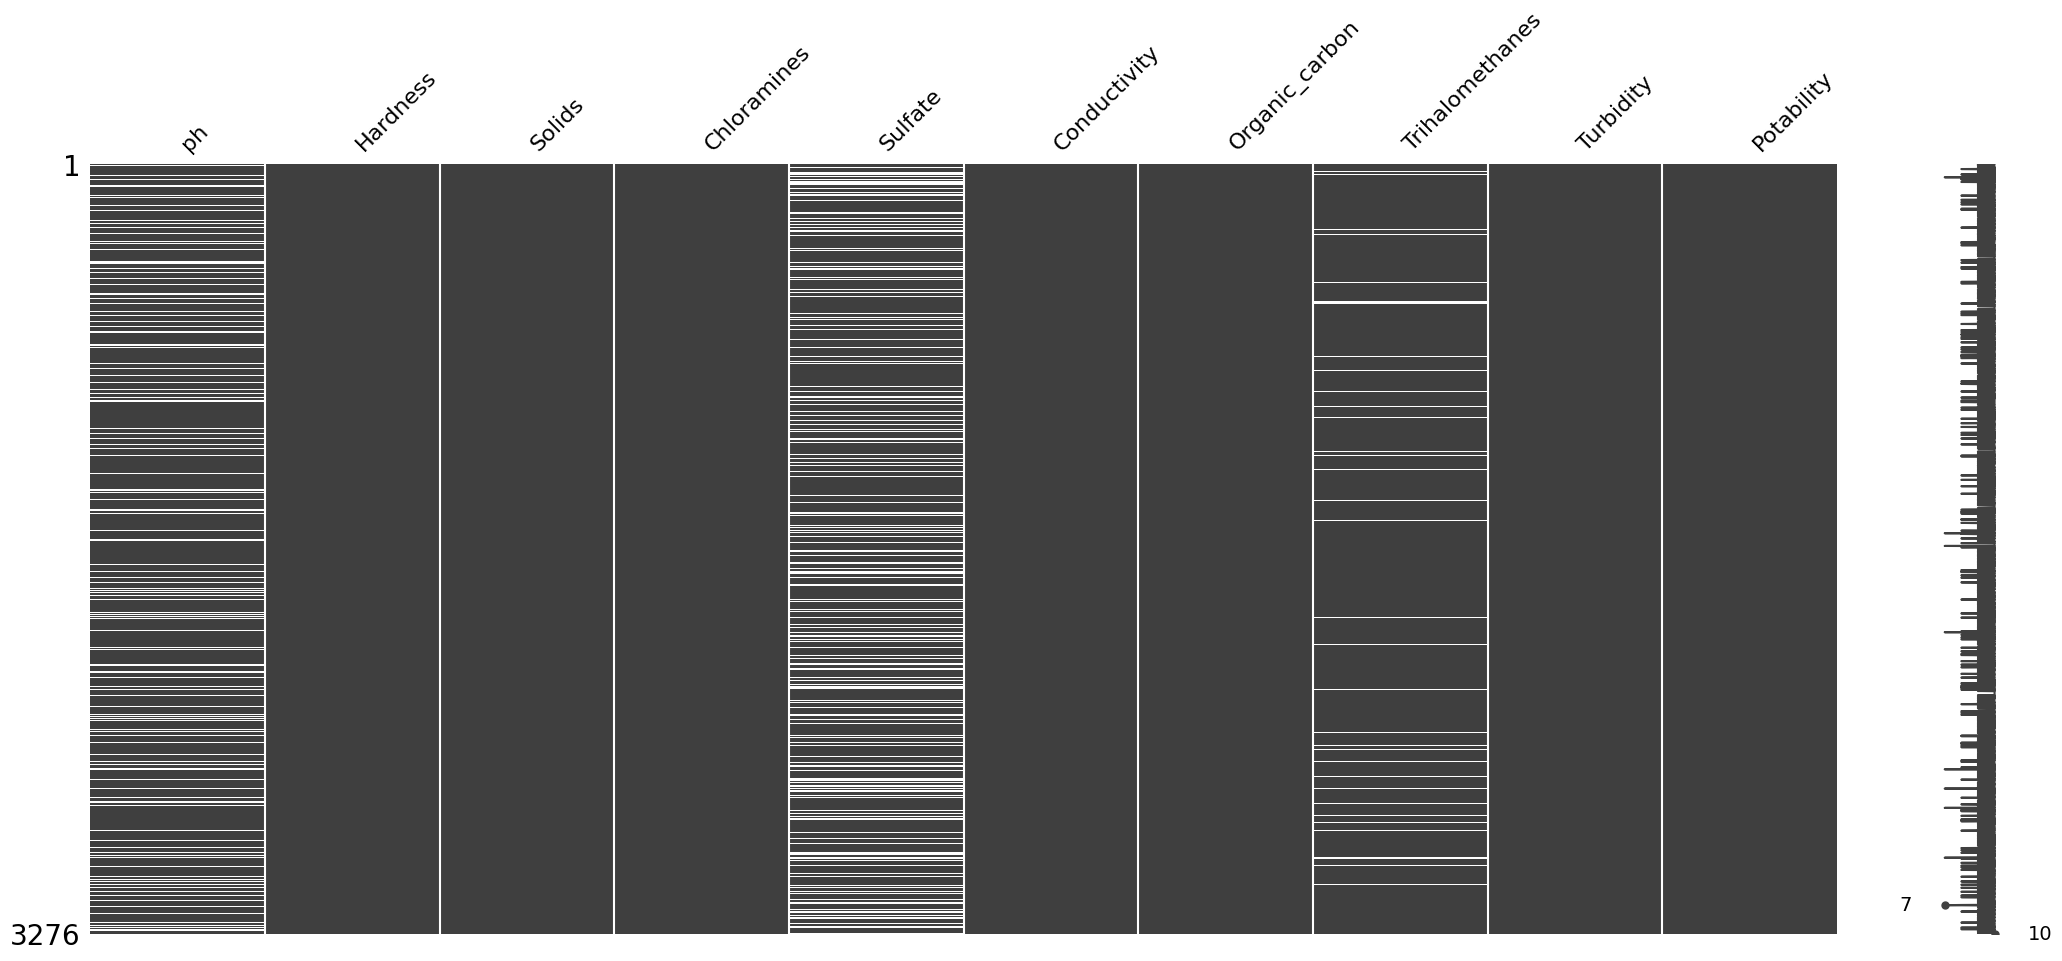

In [361]:
msno.matrix(df)
plt.show()

In [362]:
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [363]:
# handle missing value with median of features

df["ph"].fillna(value = df["ph"].median(), inplace = True)
df["Sulfate"].fillna(value = df["Sulfate"].median(), inplace = True)
df["Trihalomethanes"].fillna(value = df["Trihalomethanes"].median(), inplace = True)

In [364]:
df.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [365]:
#Preprocessing: Train-Test_Split and Normalization

In [366]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold, train_test_split
from sklearn.metrics import precision_score, confusion_matrix
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import json
import joblib # for saving algorithm and preprocessing objects
import numpy as np # for data manipulation
from xgboost import XGBClassifier

In [367]:
X = df.drop("Potability", axis = 1).values
y = df["Potability"].values
# x_cols = [c for c in df.columns if c != 'Potability']
# # set input matrix and target column
# X = df[x_cols]
# y = df['Potability']
# # show first rows of data
# df.head()

In [368]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 3)
print("X_train",X_train.shape)
print("X_test",X_test.shape)
print("y_train",y_train.shape)
print("y_test",y_test.shape)

X_train (2293, 9)
X_test (983, 9)
y_train (2293,)
y_test (983,)


In [369]:
# # fill missing values
# train_mode = dict(X_train.mode().iloc[0])
# X_train['ph'] = X_train.fillna(train_mode)
# X_train["ph"].fillna(value = train_mode["ph"], inplace = True)
# X_train["Sulfate"].fillna(value = train_mode["Sulfate"], inplace = True)
# X_train["Trihalomethanes"].fillna(value = train_mode["Trihalomethanes"], inplace = True)
# X_test["ph"].fillna(value = train_mode["ph"], inplace = True)
# X_test["Sulfate"].fillna(value = train_mode["Sulfate"], inplace = True)
# X_test["Trihalomethanes"].fillna(value = train_mode["Trihalomethanes"], inplace = True)
# df["Sulfate"].fillna(value = df["Sulfate"].median(), inplace = True)
# df["Trihalomethanes"].fillna(value = df["Trihalomethanes"].median(), inplace = True)
# print(train_mode)

In [370]:
# X_train.isnull().sum()

In [371]:
# min-max normalization
x_train_max = np.max(X_train)
x_train_min = np.min(X_train)
X_train = (X_train - x_train_min)/(x_train_max-x_train_min)
X_test = (X_test - x_train_min)/(x_train_max-x_train_min)
# X_test.isnull().sum()

In [372]:
#Modelling Decision Tree and Random Forest Classifiers

In [373]:
models = [ ("RF",RandomForestClassifier(n_estimators=100,max_features='sqrt',max_depth=10))]
         

In [374]:
finalResults = []
cmList = []
for name, model in models:
    model.fit(X_train, y_train) # train
    model_result = model.predict(X_test) # prediction
    score = precision_score(y_test, model_result)
    cm = confusion_matrix(y_test, model_result)
    
    finalResults.append((name, score))
    cmList.append((name, cm))
finalResults

[('RF', 0.6864406779661016)]

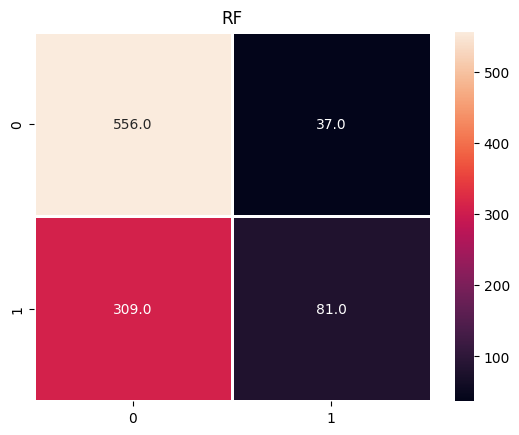

In [375]:
for name, i in cmList:
    plt.figure()
    sns.heatmap(i, annot = True, linewidths = 0.8, fmt = ".1f")
    plt.title(name)
    plt.show()

In [376]:
#Visualize Decision Tree

In [377]:
RF_clf = models[0][1]
RF_clf

RandomForestClassifier(max_depth=10)

In [378]:
# plt.figure(figsize=(25,20))
# tree.plot_tree(dt_clf,
#               feature_names = df.columns.tolist()[:-1],
#               class_names = ["0","1"],
#               filled = True,
#               precision = 5)
# plt.show()

In [379]:
#Random Forest, XGBoost, GBM Hyperparameter Tuning

In [380]:
model_params = {
    "Random Forest":
    {
        "model":RandomForestClassifier(),
        "params":
        {
            "n_estimators":[10, 50, 100],
            "max_features":["auto","sqrt","log2"],
            "max_depth":list(range(1,21,3))
        }
    }}
# ,
#     "XGBoost":
#     {
#         "model":XGBClassifier(),
#         "params":
#         {
#             "colsample_bytree":[0.6, 0.8, 1],
#             "learning_rate":[0.1, 0.2, 0.01],
#             "max_depth":list(range(1,21,3)),
#             "n_estimators":[100,200,500]
#         }
#     },
#     "GBM":
#     {
#         "model": GradientBoostingRegressor(),
#         "params":
#         {
#             "learning_rate":[0.001, 0.01, 0.1, 0.2],
#             "max_depth":list(range(1,21,3)),
#             "n_estimators":[200, 500, 1000, 2000],
#             "subsample":[1, 0.5, 0.75]
#         }
#     }
# }
model_params

{'Random Forest': {'model': RandomForestClassifier(),
  'params': {'n_estimators': [10, 50, 100],
   'max_features': ['auto', 'sqrt', 'log2'],
   'max_depth': [1, 4, 7, 10, 13, 16, 19]}}}

In [381]:
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 2)
scores = []
for model_name, params in model_params.items():
    rs = RandomizedSearchCV(params["model"], params["params"], cv = cv, n_iter = 10)
    rs.fit(X,y)
    scores.append([model_name, dict(rs.best_params_),rs.best_score_])
scores

d:\gp project\water qulaity prediction\water_quality_prediction\env\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.

d:\gp project\water qulaity prediction\water_quality_prediction\env\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.

d:\gp project\water qulaity prediction\water_quality_prediction\env\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep 

[['Random Forest',
  {'n_estimators': 100, 'max_features': 'auto', 'max_depth': 19},
  0.6721641686836716]]

In [382]:
# joblib.dump(train_mode, "./train_mode.joblib", compress=True)
# # joblib.dump(encoders, "./encoders.joblib", compress=True)
joblib.dump(RF_clf, "./random_forest.joblib", compress=True)
# # joblib.dump(et, "./extra_trees.joblib", compress=True)

['./random_forest.joblib']